# Plans
- Read data and see some examples
- Create data loader
- Create a simple early fusion model for train
- Train and single example inference
- create a explain model
- Single example explain

# Setup

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import shutil
from PIL import Image
import tqdm
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import vgg19, resnet18, densenet161

import transformers
from transformers import BertModel, BertTokenizer

In [ ]:
# Global Path Vairables
ROOT_DIR =  "drive/MyDrive/11877-AMMML/dataset/"
DATASET_DIR = ROOT_DIR + "hateful_memes/"

In [ ]:
def get_all_files_from_dir(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        file_paths += [os.path.join(root, x) for x in files]
    return sorted(file_paths)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS = 1
LEARNING_RATE = 1e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 16

# Data Preparation

In [ ]:
train_raw_json_list = []
with open(DATASET_DIR + "train.jsonl", "r") as f:
  for json_string in list(f):
    train_raw_json_list.append(json.loads(json_string))
image_paths = [x["img"] for x in train_raw_json_list]

# # Filter out images whose dimension is less than 224
# filter_image_list = []
# for i in range(len(image_paths)):
#   PIL_image = Image.open(DATASET_DIR + train_raw_json_list[i]["img"])
#   if PIL_image.size[0] < 224 or PIL_image.size[1] < 224:
#     filter_image_list.append(train_raw_json_list[i]["img"])
#     print(train_raw_json_list[i]["img"])
#   if i % 50 == 0:
#     print(i)

filter_image_list = ['img/80567.png', 'img/49270.png', 'img/58306.png', 'img/17832.png', 'img/17205.png', 'img/75428.png', 'img/42015.png', 'img/38624.png', 'img/30847.png', 'img/07312.png', 'img/74589.png', 'img/86159.png', 'img/51304.png', 'img/18296.png', 'img/69807.png', 'img/65908.png', 'img/65940.png', 'img/79854.png', 'img/93124.png', 'img/36725.png', 'img/94802.png', 'img/21043.png', 'img/09478.png', 'img/73984.png', 'img/59248.png', 'img/98412.png', 'img/26543.png', 'img/96701.png', 'img/86104.png', 'img/48579.png', 'img/84076.png', 'img/42073.png', 'img/98367.png', 'img/56193.png', 'img/41823.png', 'img/85269.png', 'img/16702.png', 'img/82156.png', 'img/90483.png', 'img/40158.png', 'img/17928.png', 'img/32781.png', 'img/58194.png', 'img/82540.png', 'img/36178.png', 'img/94150.png', 'img/16084.png', 'img/95817.png', 'img/16438.png', 'img/85147.png', 'img/65904.png', 'img/85392.png', 'img/43791.png', 'img/69025.png', 'img/79423.png', 'img/49067.png', 'img/84951.png', 'img/25310.png', 'img/23174.png', 'img/96340.png', 'img/98736.png', 'img/08741.png', 'img/10835.png', 'img/48192.png', 'img/40917.png']
image_paths = [item for item in image_paths if item not in filter_image_list]

labels = [x["label"] for x in train_raw_json_list if x["img"] not in filter_image_list]
texts = [x["text"] for x in train_raw_json_list if x["img"] not in filter_image_list]

In [ ]:
# index = 0
# cv2_image = cv2.imread(DATASET_DIR + train_raw_json_list[index]["img"])
# print(cv2_image.shape)
# print(train_raw_json_list[index]["img"])
# print(train_raw_json_list[index]["text"])
# print(train_raw_json_list[index]["label"])
# plt.imshow(cv2_image)
# plt.show()

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        super(ImageDataset, self).__init__()
        self.image_paths = [DATASET_DIR + x for x in image_paths]
        self.transform = transform
        self.idx_to_path = {i: image_path for i, image_path in enumerate(self.image_paths)}
        self.path_to_idx = {image_path: i for i, image_path in enumerate(self.image_paths)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_filepath = self.idx_to_path[idx]
        image = Image.open(image_filepath)
        if self.transform:
          try:
            image = self.transform(image)
          except:
            print(image_filepath)
        # return image, image_filepath
        return image
    
    def get_by_path(self, path):
      image, _ =  self.__getitem__(self.path_to_idx[path])
      image = image[None, :]
      return image

In [ ]:
# use the ImageNet transformation
imagenet_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

# Already double checked the order of ids in dataset and loader objects are as expected
image_dataset = ImageDataset(image_paths, imagenet_transform)
image_dataloader = DataLoader(dataset=image_dataset, batch_size=BATCH_SIZE)

In [ ]:
class TextDataset(Dataset):
  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      # pad_to_max_length=True,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
text_dataset = TextDataset(
    texts=texts,
    targets=labels,
    tokenizer=tokenizer,
    max_len=160
  )

text_dataloader = DataLoader(dataset=text_dataset, batch_size=BATCH_SIZE)

In [ ]:
assert len(image_dataloader) == len(text_dataloader)

# Model To Train

In [ ]:
class MultimodalClassifier(nn.Module):
  def __init__(self, n_classes):
    super(MultimodalClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.vgg = vgg19(pretrained=True)
    self.features_conv = self.vgg.features[:36]
    self.features_final = self.vgg.classifier[:-1]
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    self.drop = nn.Dropout(p=0.3)
    self.combined_fc1 = nn.Linear(self.bert.config.hidden_size + 4096, 256)
    self.combined_fc_final = nn.Linear(256, n_classes)
  
  def forward(self, x, input_ids, attention_mask):
    x = self.features_conv(x)
    x = self.max_pool(x)
    x = x.view((x.size(0), -1))
    x = self.features_final(x)

    last_hidden_state, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )

    combined = torch.cat((x, pooled_output), 1)
    combined = F.relu(self.combined_fc1(combined))
    combined = F.relu(self.combined_fc_final(combined))

    return combined

In [ ]:
print("Currently using device: {}\n".format(DEVICE))

model = MultimodalClassifier(n_classes=1)
model = model.to(DEVICE)
# print("Model Architecture {}\n".format(model))

Currently using device: cuda



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print("Training Started...")
criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
model.train()


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for text_features, image_features in zip(text_dataloader, image_dataloader):
    input_ids = text_features["input_ids"].to(DEVICE)
    attention_masks = text_features["attention_mask"].to(DEVICE)
    targets = text_features["targets"].to(DEVICE)
    image_features = image_features.to(DEVICE)

    model.zero_grad()
    output = model(image_features, input_ids, attention_masks)
    loss = criterion(torch.round(torch.sigmoid(output.squeeze())), targets.float())
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), CLIP)
    optimizer.step()
    
    with torch.no_grad():
      acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - targets.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_train += acc.item()
      total_loss_train += loss.item()
    
  train_acc = total_acc_train / len(text_dataloader)
  train_loss = total_loss_train / len(text_dataloader)
  print("Epoch:", epoch)
  print("Train accuracy:", train_acc)
  print("Train loss", train_loss)
  print()

torch.save(model.state_dict(), ROOT_DIR + "early_funsion.pt")

Training Started...
Epoch: 0
Train accuracy: 0.5752840909090909
Train loss 0.7554957267235626



In [ ]:
# model.load_state_dict(torch.load(ROOT_DIR + "early_funsion.pt"))

<All keys matched successfully>

In [ ]:
sample_image_path = DATASET_DIR + "img/79351.png"
sample_text = "jew mad? get fuhrerious!"

sample_image = Image.open(sample_image_path)
sample_image = imagenet_transform(sample_image)
sample_image = sample_image[None, :]


sample_encoding = tokenizer.encode_plus(
      sample_text,
      add_special_tokens=True,
      max_length=160,
      return_token_type_ids=False,
      # pad_to_max_length=True,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )
sample_image = sample_image.to(DEVICE)
sample_encoding = sample_encoding.to(DEVICE)

In [ ]:
model(sample_image, sample_encoding["input_ids"], sample_encoding["attention_mask"])

tensor([[0.]], device='cuda:0', grad_fn=<ReluBackward0>)

# Explainer

In [ ]:
# class MultimodalIntermediate(nn.Module):
#   def __init__(self, n_classes):
#     super(MultimodalIntermediate, self).__init__()
#     self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#     self.vgg = vgg19(pretrained=True)
#     self.features_conv = self.vgg.features[:36]
#     self.features_final = self.vgg.classifier[:-1]
#     self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#     self.drop = nn.Dropout(p=0.3)
#     self.combined_fc1 = nn.Linear(self.bert.config.hidden_size + 4096, 256)
#     self.combined_fc_final = nn.Linear(256, n_classes)

#     self.vision_gradients = None

#   def vision_activations_hook(self, grad):
#       self.vision_gradients = grad
  
#   def forward(self, x, input_ids, attention_mask):
#     x = self.features_conv(x)
#     h_vision = x.register_hook(self.vision_activations_hook)
#     x = self.max_pool(x)
#     x = x.view((x.size(0), -1))
#     x = self.features_final(x)

#     last_hidden_state, pooled_output = self.bert(
#       input_ids=input_ids,
#       attention_mask=attention_mask,
#       return_dict=False
#     )

#     combined = torch.cat((x, pooled_output), 1)
#     combined = F.relu(self.combined_fc1(combined))
#     combined = F.relu(self.combined_fc_final(combined))

#     return combined

#   def get_vision_gradient(self):
#     return self.vision_gradients

In [ ]:
class MultimodalExplainer(nn.Module):
  # This somehow only works for batch = 1, but this is enough for a case-by-case explainer for our current need
  def __init__(self, n_classes):
    super(MultimodalExplainer, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.vgg = vgg19(pretrained=True)
    self.features_conv = self.vgg.features[:36]
    self.features_final = self.vgg.classifier[:-1]
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    self.drop = nn.Dropout(p=0.3)
    self.combined_fc1 = nn.Linear(self.bert.config.hidden_size + 4096, 256)
    self.combined_fc_final = nn.Linear(256, n_classes)

    self.raw_image_input = None
    self.raw_language_input = None
    
    # placeholder for the gradients
    self.vision_gradients = None
    self.language_gradients = None

  # hook for the gradients of the activations
  def vision_activations_hook(self, grad):
      self.vision_gradients = grad
  
  def language_activations_hook(self, grad):
      self.language_gradients = grad

  def forward(self, x, input_ids, attention_mask):
    self.raw_image_input = x.clone().detach().cpu().numpy()
    x = self.features_conv(x)
    # h_vision = x.register_hook(self.vision_activations_hook)
    x = self.max_pool(x)
    x = x.view((x.size(0), -1))
    x = self.features_final(x)
    
    self.raw_language_input = input_ids.clone().detach().cpu().numpy()
    for module_pos, module in self.bert._modules.items():
      if module_pos == "embeddings":
        y = module(input_ids=input_ids)
        # h_language = y.register_hook(self.language_activations_hook)
      elif module_pos == "encoder":
        y = module(hidden_states=y, attention_mask=attention_mask, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None).last_hidden_state
      else:
        pooled_output = module(hidden_states=y)
        last_hidden_state = y
    
    combined = torch.cat((x, pooled_output), 1)
    combined = F.relu(self.combined_fc1(combined))
    # h_vision = combined.register_hook(self.vision_activations_hook)
    combined = F.relu(self.combined_fc_final(combined))
    return combined
  
  def get_vision_gradient(self):
    return self.vision_gradients

  def get_language_gradient(self):
    return self.language_gradients
  
   # method for the activation exctraction
  def get_vision_activations(self, x):
    return self.features_conv(x).detach().cpu().numpy()
  
  def get_language_activations(self):
    return self.raw_language_input

  def get_raw_vision_input(self):
    return self.raw_image_input

  def get_raw_language_input(self):
    return self.raw_language_input


In [ ]:
model_explainer = MultimodalExplainer(n_classes=1)
# model_explainer.load_state_dict(torch.load(ROOT_DIR + "early_funsion.pt"))
model_explainer = model_explainer.to(DEVICE)
model_explainer = model_explainer.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: ignored

In [ ]:
# outputs = model_explainer(sample_image, sample_encoding["input_ids"], None)
outputs = model_explainer(sample_image, sample_encoding["input_ids"], sample_encoding["attention_mask"])
# outputs[:, 0].backward()

In [ ]:
outputs

tensor([[0.]], device='cuda:0', grad_fn=<ReluBackward0>)

In [ ]:
vision_gradients = model_explainer.get_vision_gradient()

In [ ]:
vision_gradients

In [ ]:
vision_gradients = model_explainer.get_vision_gradient()
# pool the gradients across the channels, so that each channel have one gradient value
pooled_vision_gradients = torch.mean(vision_gradients, dim=[0, 2, 3])
pooled_vision_gradients_np = pooled_vision_gradients.detach().cpu().numpy()

# get the activations of the last convolutional layer
raw_vision_activations = model_explainer.get_vision_activations(sample_image)
vision_activations = np.zeros(raw_vision_activations.shape)

# weight the channels by corresponding gradients
for i in range(vision_activations[0].shape[0]):
  vision_activations[:, i, :, :] = raw_vision_activations[:, i, :, :] * pooled_vision_gradients_np[i]
    
# average the channels of the activations
vision_heatmap = torch.mean(torch.from_numpy(vision_activations), axis=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
vision_heatmap = np.maximum(vision_heatmap, 0)


# normalize the heatmap
vision_heatmap /= torch.max(vision_heatmap)

In [ ]:
# language_gradients = model_explainer.get_language_gradient()
# pooled_language_gradients = torch.mean(language_gradients, dim=2)
# pooled_language_gradients_np = pooled_language_gradients.detach().cpu().numpy()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


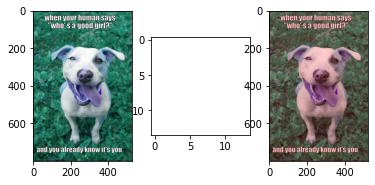

Darker-color heatmap indicate strong correlation between the region and predicted class


In [ ]:
# Plot heatmap together with the image from ORIGINAL RESOLUTION
plot_image = cv2.imread(sample_image_path)
updated_vision_heatmap = cv2.resize(np.array(vision_heatmap), (plot_image.shape[1], plot_image.shape[0]))
updated_vision_heatmap = np.uint8(255 * updated_vision_heatmap)
updated_vision_heatmap = cv2.applyColorMap(updated_vision_heatmap, cv2.COLORMAP_JET)
superimposed_img = updated_vision_heatmap * 0.5 + plot_image

f = plt.figure()
f.add_subplot(1, 3, 1)
plt.imshow(plot_image)
f.add_subplot(1, 3, 2)
plt.imshow(vision_heatmap)
f.add_subplot(1, 3, 3)
plt.imshow(superimposed_img / np.max(superimposed_img))
plt.show(block=True)
print("Darker-color heatmap indicate strong correlation between the region and predicted class")

In [ ]:
updated_vision_heatmap

array([[[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       ...,

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]]